# U-Net Segmentation

A more sophisticated approach is needed to segment the wires from the images. Multiple ones are available but the first one used is the U-Net. 



In [1]:
# import modules (download with pip install first if not on local. Type on terminal: pip install <module name>)
import torch
import torch.nn as nn
import torch.nn.functional as F #contains some useful functions like activation functions & convolution operations you can use
import numpy as np
import os

# install torchvision first

device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print("Using",device,"...")

Using cuda:0 ...


## Dataset

In [2]:
from load_data import *
# X, y = load_data('/content/drive/My Drive/AIWIRE', 'dataset')
# X, y = load_data('.', 'small_dataset')
X, y = load_data('.', '../data/dataset_all_1', v73=True)
print(X.shape)

(7000, 256, 192)


In [3]:
import dataset
from imgaug import augmenters as iaa 
from sklearn.model_selection import train_test_split
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

batch_size = 50
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
test_proportion = 0.2
test_length = round(y.shape[0] * test_proportion)
X_train, y_train, X_test, y_test = X[:-test_length], y[:-test_length], X[-test_length:], y[-test_length:]
dataloaders = dataset.gen_dataloaders(X_train, X_test, y_train, y_test, batch_size)

# Initialize augmentation types 
seq = iaa.Sequential([
    iaa.Sometimes(1.0,
                  iaa.Fliplr(0.5)),
    iaa.Sometimes(0.4,
        iaa.Affine(
        scale = {"x": (1.0,1.2), "y": (1.0,1.2)}
        )
    )
])

# Function that applies augmentation to batch during training
def apply_augmentation(images,masks):
    
    ims_aug=torch.zeros([len(images),1,*images.shape[-2:]],dtype=torch.float64)
    mask_aug=torch.zeros([len(masks),*masks.shape[-2:]],dtype=torch.float64)
    
    for i, (image, mask) in enumerate(zip(images, masks)): 
        segmap = np.squeeze(mask.numpy())
        segmap = SegmentationMapsOnImage(segmap, shape=image.shape)
        im_aug, gt_aug = seq(images=np.squeeze(image.numpy()), segmentation_maps=segmap)
        gt_aug = gt_aug.get_arr().astype(float)
        im_aug, gt_aug = torch.from_numpy(im_aug),torch.from_numpy(gt_aug)
        ims_aug[i,0] = im_aug
        mask_aug[i] = gt_aug
        
    return ims_aug, mask_aug 

{'train': 5600, 'val': 1400}


In [4]:
from scipy.ndimage import gaussian_filter

def norm(im):
    im -= im.min()
    im = im / im.max()
    return im

def weighted_BCE(weights=None):
    def weighted_binary_cross_entropy(output, target):
        if weights is not None:
            assert len(weights) == 2

            loss = weights[1] * (target * torch.log(output)) + \
                   weights[0] * ((1 - target) * torch.log(1 - output))
        else:
            loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

        return torch.neg(torch.mean(loss))
    return weighted_binary_cross_entropy

torch.Size([1, 256, 192]) torch.Size([256, 192])
Showing images
torch.Size([1, 256, 192]) torch.Size([1, 256, 192])
Class balance (one sigma): 0.6429036458333334%
Loss for null model: 0.025937252979124043


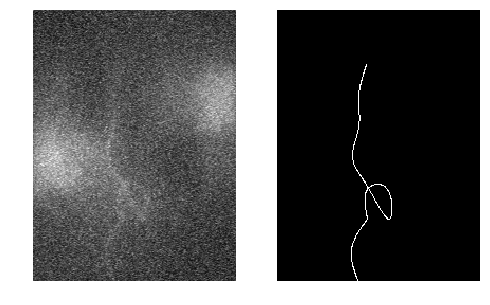

torch.Size([1, 256, 192]) torch.Size([1, 256, 192])
Class balance (one sigma): 0.6571451822916666%
Loss for null model: 0.026403718660411357


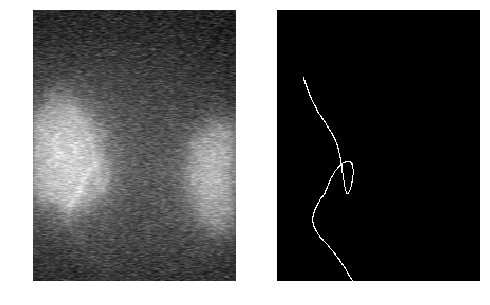

torch.Size([1, 256, 192]) torch.Size([1, 256, 192])
Class balance (one sigma): 0.6429036458333334%
Loss for null model: 0.025937252979124043


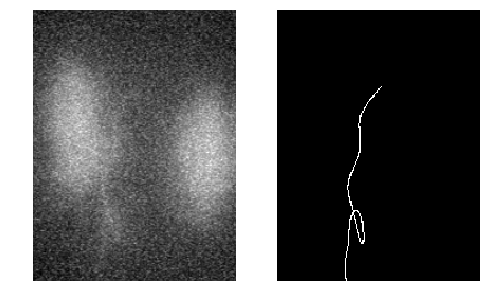

In [6]:
import matplotlib.pyplot as plt

# loss_function = nn.MSELoss()
class_weighting_multiplier = 3/4
loss_function = weighted_BCE(weights = torch.Tensor([1 - class_weighting_multiplier, class_weighting_multiplier]))

def show(im):
    plt.imshow(im, cmap='gray')
    plt.axis('off')

    
print(dataloaders['train'])
n = 3
first_batch = next(iter(dataloaders['train']))

ims = first_batch[0][:n]
gts = first_batch[1][:n].float()
# gts = first_batch[1][:n].numpy()

print(ims[0].shape, gts[0].shape)
# h2 = plt.hist(gts[0].numpy().mean(1), density = True, alpha=1)
# plt.title('Ground truth row means histogram')
# plt.show()
# h2 = plt.hist(ims[0].mean(1), density = True, alpha=1)
# plt.title('Image row means histogram')
# plt.show()

print('Showing images')
for [im], gt in zip(ims, gts):
    segmap = gt.numpy()
    segmap = SegmentationMapsOnImage(segmap,shape=im.shape)
    im, gt = apply_augmentation(im.unsqueeze(0).unsqueeze(0), gt.unsqueeze(0))
    im, gt = im.squeeze(0).squeeze(0), gt.squeeze(0)

    # Plotting
    plt.figure(figsize=[8]*2)
    plt.subplot(121)
    show(im)

    plt.subplot(122)
    show(gt)
    
    # Statistics
    print(torch.Tensor(np.ones(gt.shape) * np.average(gt)).unsqueeze(0).shape, gt.unsqueeze(0).shape)
    base_loss = loss_function(torch.Tensor(np.ones(gt.shape) * np.average(gt)).unsqueeze(0), gt.unsqueeze(0))
    print(f'Class balance (one sigma): {100 * torch.sum((gt - np.std(gt.numpy())) > 0).item() / np.prod(gt.shape)}%')
    print('Loss for null model:', base_loss.item())
    
    plt.show()

## Model

In [7]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
print(inputs.dtype, masks.dtype)

for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

# install torchsummary first
from torchsummary import summary
# import model from python file
import Unet_pytorch
import importlib
importlib.reload(Unet_pytorch)

num_class = 1
model = Unet_pytorch.UNet(num_class)
model = model.to(device)

print("MODEL ARCHITECTURE ...")
summary(model, input_size=ims[0].shape)

save_path = '../saved_models/unet_noise_1'

torch.Size([50, 1, 256, 192]) torch.Size([50, 256, 192])
torch.float64 torch.float64
0.0035145163871582057 1.7385282149860362 0.44741155067638233 0.25254418164183984
0.0 1.0 0.0057584635416666665 0.07566573623051559
MODEL ARCHITECTURE ...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 192]             320
       BatchNorm2d-2         [-1, 32, 256, 192]              64
              ReLU-3         [-1, 32, 256, 192]               0
            Conv2d-4         [-1, 32, 256, 192]           9,248
       BatchNorm2d-5         [-1, 32, 256, 192]              64
              ReLU-6         [-1, 32, 256, 192]               0
         MaxPool2d-7          [-1, 32, 128, 96]               0
            Conv2d-8          [-1, 64, 128, 96]          18,496
       BatchNorm2d-9          [-1, 64, 128, 96]             128
             ReLU-10          [-1, 64, 128, 96]         

## Training

In [8]:
from torch.utils.tensorboard import SummaryWriter
import datetime
writer = SummaryWriter('./logs/{0}'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt
def visualise(outputs, title, n=7):
    fig = plt.figure(figsize=[10, 3])
    fig.suptitle(title, fontsize=14)
    for i, output in enumerate(outputs[:n]):
        plt.subplot(1,n,i+1)
        plt.axis('off')
        plt.imshow(output) if output.shape[0] == 3 else plt.imshow(output, cmap='gray')
    plt.show()

In [ ]:
from collections import defaultdict
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import copy

def train_model(model, optimizer, scheduler = None, num_epochs=25, train_stats_period=10):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step() if scheduler is not None else None
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_samples = 0
            loss_vec = []

            for batch_id, (inputs, labels) in enumerate(dataloaders[phase]):
                [inputs,labels] = apply_augmentation(inputs,labels)
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    loss = loss_function(torch.squeeze(outputs), labels.type(torch.float32))
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #print (loss.item())
                    loss_vec.append(loss.item())  

                    if batch_id % train_stats_period == 0:
                        print('Batch', batch_id, ':', loss.item())

                # statistics
                epoch_samples += inputs.size(0)

            # print loss at every epoch 
            epoch_loss = np.mean(np.asarray(loss_vec), dtype=np.float32)
            #epoch_loss = np.mean(np.asarray(loss_vec), dtype=np.float32)/float(epoch_samples)
            print('Loss ' + phase, ': {:.8f}'.format(epoch_loss))
            writer.add_scalar('Loss ' + phase, epoch_loss, epoch)

            if phase == 'val':
                visualise(inputs.squeeze(1).cpu().numpy(), 'Simulated images')
                preds = outputs.squeeze(1).cpu().numpy()
                visualise(preds, 'Network catheter predictions')
                colour_outputs = outputs.repeat(1, 3, 1, 1).permute(0, 2, 3, 1).cpu().numpy()
                colour_outputs = norm(colour_outputs)
                red_labels = np.zeros(colour_outputs.shape)
                red_labels[:,:,:,0] = labels.cpu() * (1.3 - preds)
                red_labels[:,:,:,1] = labels.cpu() * preds
                overlay = colour_outputs + red_labels
                overlay = norm(overlay)
                visualise(overlay, 'Predictions with ground truth overlay')
                
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                torch.save(model.state_dict(), save_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

# model = Unet_pytorch.UNet(num_class).float()
# model = model.to(device)

optimizer_ft = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9) 

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

train_model(model, optimizer_ft, num_epochs=100)

Epoch 0/99
----------
LR 0.01


/vol/bitbucket/rh2515/CrohnsDisease/venv/lib/python3.6/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Batch 0 : 0.16712483763694763
Batch 10 : 0.1346716284751892
Batch 20 : 0.09591595083475113
Batch 30 : 0.06976238638162613
Batch 40 : 0.05455094948410988
Batch 50 : 0.04463865980505943
Batch 60 : 0.03815774619579315
Batch 70 : 0.03400195389986038
Batch 80 : 0.031406693160533905
Batch 90 : 0.02924942970275879


## Evaluate on <u>real</u> data

Loading ../saved_models/unet_noise_1
Performance on real data


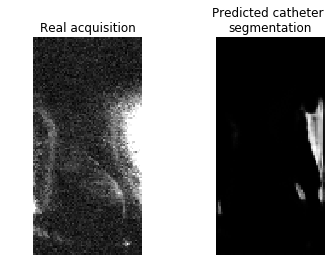

In [9]:
print(f'Loading {save_path}')
model.load_state_dict(torch.load(save_path))
model = model.to(device)
model.eval()

def infer(model, im):
    im = torch.Tensor(im).unsqueeze(0).unsqueeze(0).to(device)
    return model(im).squeeze(0).squeeze(0).cpu().detach().numpy()

print('Performance on real data')
import imageio
from PIL import Image
gif = imageio.get_reader('../data/cropped_gif.gif')
test_im = np.array(list(gif))[100]
test_im = np.array(Image.fromarray(test_im).resize([64, 128]))
test_im = norm(test_im)
# test_im = norm(np.array(Image.fromarray(test_im).resize([64, 128])))
plt.subplot(121)
show(test_im)
plt.title('Real acquisition')

# test_im = torch.Tensor(ims[0].float()).unsqueeze(0).to(device)
test_pred = infer(model, test_im)
plt.subplot(122)
show(test_pred)
plt.title('Predicted catheter \nsegmentation')
plt.show()

### Testing skeletonisation

Skeletonisation
torch.Size([50, 1, 256, 192])


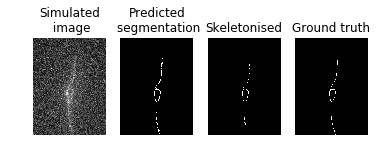

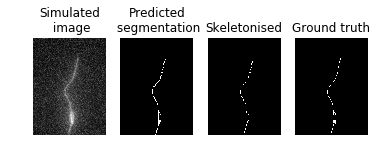

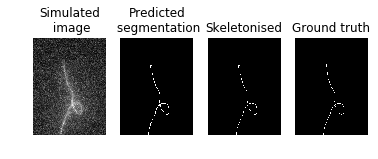

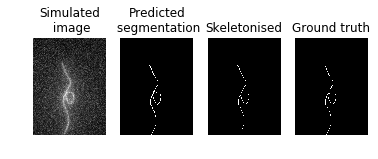

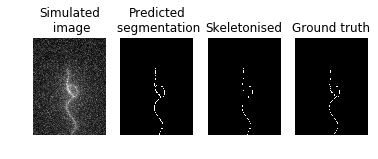

In [10]:
print('Skeletonisation')
from skimage.morphology import skeletonize
ims = first_batch[0]
gts = first_batch[1].float()
output_folder = 'output'
print(ims.shape)

import imageio

for i in range(5):
    test_im = np.squeeze(ims[i]).float()

    plt.subplot(141)
    show(test_im)
    plt.title('Simulated\n image')

    plt.subplot(144)
    show(np.squeeze(gts[i]))
    plt.title('Ground truth')

    sim_pred = infer(model, test_im)
    plt.subplot(142)
    show(sim_pred > 0.5)
    plt.title('Predicted\n segmentation')

    skeleton = 255 * skeletonize(sim_pred > 0.5)
    plt.subplot(143)
    show(skeleton)
    plt.title('Skeletonised')
    imageio.imwrite(os.path.join(output_folder, f'skeletonised_{i}.png'), skeleton.astype(np.uint8))
    
    plt.show()